In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 16.5 MB/s 
     |████████████████████████████████| 831.4 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
# Import required packages
import os
import sys
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import random
import time
import spacy

from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
import torch
import torchtext.legacy
from torchtext.legacy import data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.nn import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#os.getcwd()

Mounted at /content/drive


In [ ]:
path_to_utils='/content/drive/My Drive/NLP'
sys.path.append(path_to_utils)

In [ ]:
os.chdir(path_to_utils)

print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1qJ8h8Q6C6t_FWn4R8pQeH813twKX9HgP/NLP


In [ ]:
#params can act as config file here

params={"Network": {"seed": 1},
        "display_stats_freq": 200,
        "network_save_freq": 1,
        "postreply_data_path": "./",
        #"input_data_path": "./data/datasets/semeval_message_level/",
        #"train_file_name": "training_data.txt",
        #"test_file_name": "test_data.txt",
        #"reply_file_name": "data_post_reply.csv",
        #"reply_with_label_file_name": "data_post_reply_withlabel.csv",
        "final_data_post_reply_file_name": "final_data_post_reply.csv",
        "training_post_reply_file_name": "obtained_train.csv", #obtained_train.csv, provided_train.csv, obtained_train_clean.csv, provided_train_clean.csv
        #"philipp_data": "philipp_data.csv",
        #"philipp_with_label_file_name": "philipp_withlabel.csv",
        #"philipp_final_post_reply_file_name": "philipp_final.csv",
        "final_test_post_reply_file_name": "test_w_text.csv",
        #"data_format": "tsv",
        "reply_data_format": "csv",
        "pretrained_embedding": "glove.twitter.27B.200d",
        "tokenizer": "spacy",
        "network_output_path": "./models/",
        #"output_data_path": "./data/output_data/",
        #"tb_logs_path": "./data/tensor_board_logs/",
        #"checkpoint_name": "checkpoint.tar",
        "trained_model_name": "LSTM_model_obt.pth"
        }

In [ ]:
from enum import Enum

class Mode(Enum):
    '''
    Class Enumerating the 3 modes of operation of the network.
    This is used while loading datasets
    '''
    TRAIN = 0
    VALID = 1
    TEST = 2
    PREDICTION = 3
    REPLYPREDICTION = 4

In [ ]:
class data_provider_PostReply():
    '''
    Packed padded sequences
    Tokenizer: spacy
    '''
    def __init__(self, params, batch_size=1, split_ratio=0.8, max_vocab_size=25000, mode=Mode.TRAIN, model_mode='RNN', seed=1): #cfg_path
        '''
        Args:
            cfg_path (string): #deprecated for first pass
                Config file path of the experiment

            params
            max_vocab_size (int):
                The number of unique words in our training set is usually over 100,000,
                which means that our one-hot vectors will have over 100,000 dimensions! SLOW TRAINIG!
                We only take the top max_vocab_size most common words.
            split_ratio (float):
                train-valid splitting
            mode (enumeration Mode):
                Nature of operation to be done with the data.
                Possible inputs are Mode.PREDICTION, Mode.TRAIN, Mode.VALID, Mode.TEST
                Default value: Mode.TRAIN
        '''
        #params = read_config(cfg_path)
        #self.cfg_path = cfg_path
        self.mode = mode
        self.seed = seed
        self.split_ratio = split_ratio
        self.max_vocab_size = max_vocab_size
        self.dataset_path = params['postreply_data_path']
        self.train_file_name = params['training_post_reply_file_name']
        self.test_file_name = params['final_test_post_reply_file_name']
        self.data_format = params['reply_data_format']
        self.pretrained_embedding = params['pretrained_embedding']
        self.tokenizer = params['tokenizer']
        self.batch_size = batch_size
        self.model_mode = model_mode


    def data_loader(self):
        '''
        :include_lengths: Packed padded sequences: will make our RNN only process the non-padded elements of our sequence,
            and for any padded element the `output` will be a zero tensor.
            Note: padding is done by adding <pad> (not zero!)
        :tokenize: the "tokenization" (the act of splitting the string into discrete "tokens") should be done using the spaCy tokenizer.
        '''
        if self.model_mode == 'RNN':
            #Packed padded sequences
            TEXT = data.Field(tokenize=self.tokenizer, include_lengths=True)  # For saving the length of sentences
        if self.model_mode == 'CNN':
            TEXT = data.Field(tokenize=self.tokenizer, batch_first=True)  # batch dimension is the firs dimension here.
        LABEL = data.LabelField()

        fields = [('label', LABEL), ('id', None), ('text', TEXT)]

        train_data, test_data = data.TabularDataset.splits(
            path=self.dataset_path,
            train=self.train_file_name,
            test=self.test_file_name,
            format=self.data_format,
            fields=fields,
            skip_header=True)

        #print(train_data)

        # validation data
        if self.split_ratio == 1:
            valid_data = None
        else:
            train_data, valid_data = train_data.split(random_state=random.seed(self.seed), split_ratio=self.split_ratio)

        # create the vocabulary only on the training set!!!
        # vectors: instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
        # initialize words in your vocabulary but not in your pre-trained embeddings to Gaussian
        TEXT.build_vocab(train_data, max_size=self.max_vocab_size,
                         vectors=self.pretrained_embedding, unk_init=torch.Tensor.normal_)
        # TEXT.build_vocab(train_data, max_size=self.max_vocab_size)

        LABEL.build_vocab(train_data)

        labels = LABEL.vocab.itos
        vocab_idx = TEXT.vocab.stoi

        vocab_size = len(TEXT.vocab)
        pretrained_embeddings = TEXT.vocab.vectors

        # the indices of the padding token <pad> and <unk> in the vocabulary
        PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
        UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
        # What do we do with words that appear in examples but we have cut from the vocabulary?
        # We replace them with a special unknown or <unk> token.


        # for packed padded sequences all of the tensors within a batch need to be sorted by their lengths
        if self.split_ratio == 1:
            valid_iterator = None
            train_iterator, test_iterator = data.BucketIterator.splits((
                train_data, test_data), batch_size=self.batch_size,
                sort_within_batch=True, sort_key=lambda x: len(x.text))
        else:
            train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((
                train_data, valid_data, test_data), batch_size=self.batch_size,
                sort_within_batch=True, sort_key=lambda x: len(x.text))

        # finding the weights of each label
        data_for_weight = pd.read_csv(os.path.join(self.dataset_path, self.train_file_name))
        pos_counter = 0
        neg_counter = 0
        neut_counter = 0
        for i in range(len(data_for_weight['label'])):
            if (data_for_weight['label'][i] == 'positive'):
                pos_counter += 1
            if (data_for_weight['label'][i] == 'negative'):
                neg_counter += 1
            if (data_for_weight['label'][i] == 'neutral'):
                neut_counter += 1
        overall = neut_counter + pos_counter + neg_counter
        neut_weight = overall/neut_counter
        neg_weight = overall/neg_counter
        pos_weight = overall/pos_counter
        if labels == ['neutral', 'negative', 'positive']:
            weights = torch.Tensor([neut_weight, neg_weight, pos_weight])
        elif labels == ['neutral', 'positive', 'negative']:
            weights = torch.Tensor([neut_weight, pos_weight, neg_weight])
        elif labels == ['negative', 'neutral', 'positive']:
            weights = torch.Tensor([neg_weight, neut_weight, pos_weight])
        elif labels == ['negative', 'positive', 'neutral']:
            weights = torch.Tensor([neg_weight, pos_weight, neut_weight])
        elif labels == ['positive', 'negative', 'neutral']:
            weights = torch.Tensor([pos_weight, neg_weight, neut_weight])
        elif labels == ['positive', 'neutral', 'negative']:
            weights = torch.Tensor([pos_weight, neut_weight, neg_weight])

        if self.mode == Mode.TEST:
            return test_iterator
        elif self.mode == Mode.PREDICTION:
            return labels, vocab_idx, vocab_size, PAD_IDX, UNK_IDX, pretrained_embeddings, labels
        else:
            return train_iterator, valid_iterator, vocab_size, PAD_IDX, UNK_IDX, pretrained_embeddings, weights, labels

In [ ]:
import datetime

class Training:
    '''
    This class represents training process.
    '''
    def __init__(self, params, num_epochs=10, RESUME=False, model_mode='RNN', torch_seed=None): #cfg_path
        '''
        :cfg_path (string): path of the experiment config file
        :torch_seed (int): Seed used for random generators in PyTorch functions
        '''
        self.params = params
        #self.cfg_path = cfg_path
        self.RESUME = RESUME
        self.model_mode = model_mode
        self.num_epochs = num_epochs

        if RESUME == False:
            self.model_info = self.params['Network']
            self.model_info['seed'] = torch_seed or self.model_info['seed']
            self.epoch = 0
            self.num_epochs = num_epochs
            self.best_loss = float('inf')
            if 'trained_time' in self.model_info:
                self.raise_training_complete_exception()
            self.setup_cuda()
            #self.writer = SummaryWriter(log_dir=os.path.join(self.params['tb_logs_path']))


    def setup_cuda(self, cuda_device_id=0):
        if torch.cuda.is_available():
            torch.backends.cudnn.fastest = True
            torch.cuda.set_device(cuda_device_id)
            self.device = torch.device('cuda')
            torch.cuda.manual_seed_all(self.model_info['seed'])
            torch.manual_seed(self.model_info['seed'])
        else:
            self.device = torch.device('cpu')


    def setup_model(self, model, optimiser, optimiser_params, loss_function, weight):

        total_param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Total # of model\'s trainable parameters: {total_param_num:,}')
        print('----------------------------------------------------\n')

        self.model = model.to(self.device)
        self.optimiser = optimiser(self.model.parameters(), **optimiser_params)
        # self.loss_function = loss_function()
        self.loss_function = loss_function(weight=weight.to(self.device))

        if 'retrain' in self.model_info and self.model_info['retrain']==True:
            self.load_pretrained_model()

        # Saves the model, optimiser,loss function name for writing to config file
        self.model_info['total_param_num'] = total_param_num
        self.model_info['optimiser'] = optimiser.__name__
        self.model_info['loss_function'] = loss_function.__name__
        self.model_info['optimiser_params'] = optimiser_params
        self.params['Network']=self.model_info
        #write_config(self.params, self.cfg_path,sort_keys=True)


    def load_checkpoint(self, model, optimiser, optimiser_params, loss_function, weight):

        checkpoint = torch.load(self.params['network_output_path'] + '/' + self.params['checkpoint_name'])
        self.device = None
        self.model_info = checkpoint['model_info']
        self.setup_cuda()
        self.model = model.to(self.device)
        self.optimiser = optimiser(self.model.parameters(), **optimiser_params)
        self.loss_function = loss_function(weight=weight.to(self.device))

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epoch = checkpoint['epoch']
        self.loss_function = checkpoint['loss']
        self.best_loss = checkpoint['best_loss']
        #self.writer = SummaryWriter(log_dir=os.path.join(self.params['tb_logs_path']), purge_step=self.epoch + 1)


    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs


    def execute_training(self, train_loader, valid_loader=None, batch_size=1):
        '''
        Executes training by running training and validation at each epoch
        '''
        self.params = params #read_config(self.cfg_path)

        total_start_time = time.time()

        if self.RESUME == False:
            # Checks if already trained
            if 'trained_time' in self.model_info:
                self.raise_training_complete_exception

            self.model_info = self.params['Network']
            self.model_info['num_epoch'] = self.num_epochs or self.model_info['num_epoch']

        print('Starting time:' + str(datetime.datetime.now()) +'\n')

        for epoch in range(self.num_epochs - self.epoch):
            self.epoch += 1
            start_time = time.time()

            print('Training (intermediate metrics):')
            train_loss, train_acc, train_F1, train_recall, train_precision = self.train_epoch(train_loader, batch_size)

            if valid_loader:
                print('\nValidation (intermediate metrics):')
                valid_loss, valid_acc, valid_F1, valid_recall, valid_precision = self.valid_epoch(valid_loader, batch_size)

            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)
            total_mins, total_secs = self.epoch_time(total_start_time, end_time)

            # Writes to the tensorboard after number of steps specified.
            #if valid_loader:
            #    self.calculate_tb_stats(train_loss, train_F1, train_recall, train_precision, train_acc,
            #                            valid_loss, valid_F1, valid_recall, valid_precision, valid_acc)
            #else:
            #    self.calculate_tb_stats(train_loss, train_F1, train_recall, train_precision, train_acc)

            # Saving the model
            if valid_loader:
                if valid_loss < self.best_loss:
                    self.best_loss = valid_loss
                    torch.save(self.model.state_dict(), self.params['network_output_path'] + '/' + self.params['trained_model_name'])
            else:
                if train_loss < self.best_loss:
                    self.best_loss = train_loss
                    torch.save(self.model.state_dict(), self.params['network_output_path'] + '/' + self.params['trained_model_name'])

            # saving the model based on epoch, checkpoint
            #self.savings()

            # Print accuracy, F1, and loss after each epoch
            print('\n---------------------------------------------------------------')
            print(f'Epoch: {self.epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | '
                  f'Total Time so far: {total_mins}m {total_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}% | Train F1: {train_F1:.3f}')
            if valid_loader:
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}% |  Val. F1: {valid_F1:.3f}')
            print('---------------------------------------------------------------\n')


    def train_epoch(self, train_loader, batch_size):
        '''
        Train using one single iteration of all messages (epoch) in dataset
        '''
        print("Epoch [{}/{}]".format(self.epoch, self.model_info['num_epoch']))
        self.model.train()
        previous_idx = 0

        # initializing the loss list
        batch_loss = 0
        batch_count = 0

        # initializing the caches
        logits_cache = torch.from_numpy(np.zeros((len(train_loader) * batch_size, 3)))
        max_preds_cache = torch.from_numpy(np.zeros((len(train_loader) * batch_size, 1)))
        labels_cache = torch.from_numpy(np.zeros(len(train_loader) * batch_size))

        for idx, batch in enumerate(train_loader):
            if self.model_mode == "RNN":
                message, message_lengths = batch.text
            if self.model_mode == "CNN":
                message = batch.text
            label = batch.label
            message = message.long()
            label = label.long()
            message = message.to(self.device)
            label = label.to(self.device)

            self.optimiser.zero_grad()

            with torch.set_grad_enabled(True):
                if self.model_mode == "RNN":
                    output = self.model(message, message_lengths).squeeze(1)
                if self.model_mode == "CNN":
                    output = self.model(message).squeeze(1)

                # Loss
                loss = self.loss_function(output, label)
                batch_loss += loss.item()
                batch_count += 1
                max_preds = output.argmax(dim=1, keepdim=True)  # get the index of the max probability

                # saving the logits and labels of this batch
                for i, batch_vector in enumerate(max_preds):
                    max_preds_cache[idx * batch_size + i] = batch_vector
                for i, batch_vector in enumerate(output):
                    logits_cache[idx * batch_size + i] = batch_vector
                for i, value in enumerate(label):
                    labels_cache[idx * batch_size + i] = value

                loss.backward()
                self.optimiser.step()

                # Prints loss statistics after number of steps specified.
                if (idx + 1)%self.params['display_stats_freq'] == 0:
                    print('Epoch {:02} | Batch {:03}-{:03} | Train loss: {:.3f}'.
                          format(self.epoch, previous_idx, idx, batch_loss / batch_count))
                    previous_idx = idx + 1
                    batch_loss = 0
                    batch_count = 0

        '''Metrics calculation over the whole set'''
        max_preds_cache = max_preds_cache.cpu()
        labels_cache = labels_cache.cpu()

        # average=None gives individual scores for each class
        # here we only care about the average of positive class and negative class
        epoch_accuracy = metrics.accuracy_score(labels_cache, max_preds_cache)
        # epoch_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average='macro')
        # epoch_precision = metrics.precision_score(labels_cache, max_preds_cache, average='macro')
        # epoch_recall = metrics.recall_score(labels_cache, max_preds_cache, average='macro')

        epoch_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average=None)
        epoch_precision = metrics.precision_score(labels_cache, max_preds_cache, average=None)
        epoch_recall = metrics.recall_score(labels_cache, max_preds_cache, average=None)
        epoch_f1_score = (epoch_f1_score[1] + epoch_f1_score[2]) / 2
        epoch_precision = (epoch_precision[1] + epoch_precision[2]) / 2
        epoch_recall = (epoch_recall[1] + epoch_recall[2]) / 2
        labels_cache = labels_cache.long()
        logits_cache = logits_cache.float()

        # Loss
        loss = self.loss_function(logits_cache.to(self.device), labels_cache.to(self.device))
        epoch_loss = loss.item()

        return epoch_loss, epoch_accuracy, epoch_f1_score, epoch_precision, epoch_recall


    def valid_epoch(self, valid_loader, batch_size):
        '''Test (validation) model after an epoch and calculate loss on valid dataset'''
        print("Epoch [{}/{}]".format(self.epoch, self.model_info['num_epoch']))
        self.model.eval()
        previous_idx = 0

        with torch.no_grad():
            # initializing the loss list
            batch_loss = 0
            batch_count = 0

            # initializing the caches
            logits_cache = torch.from_numpy(np.zeros((len(valid_loader) * batch_size, 3)))
            max_preds_cache = torch.from_numpy(np.zeros((len(valid_loader) * batch_size, 1)))
            labels_cache = torch.from_numpy(np.zeros(len(valid_loader) * batch_size))

            for idx, batch in enumerate(valid_loader):
                if self.model_mode == "RNN":
                    message, message_lengths = batch.text
                if self.model_mode == "CNN":
                    message = batch.text
                label = batch.label
                message = message.long()
                label = label.long()
                message = message.to(self.device)
                label = label.to(self.device)
                if self.model_mode == "RNN":
                    output = self.model(message, message_lengths).squeeze(1)
                if self.model_mode == "CNN":
                    output = self.model(message).squeeze(1)

                # Loss
                loss = self.loss_function(output, label)
                batch_loss += loss.item()
                batch_count += 1
                max_preds = output.argmax(dim=1, keepdim=True)  # get the index of the max probability

                # saving the logits and labels of this batch
                for i, batch_vector in enumerate(max_preds):
                    max_preds_cache[idx * batch_size + i] = batch_vector
                for i, batch_vector in enumerate(output):
                    logits_cache[idx * batch_size + i] = batch_vector
                for i, value in enumerate(label):
                    labels_cache[idx * batch_size + i] = value

                # Prints loss statistics after number of steps specified.
                if (idx + 1)%self.params['display_stats_freq'] == 0:
                    print('Epoch {:02} | Batch {:03}-{:03} | Val. loss: {:.3f}'.
                          format(self.epoch, previous_idx, idx, batch_loss / batch_count))
                    previous_idx = idx + 1
                    batch_loss = 0
                    batch_count = 0

        '''Metrics calculation over the whole set'''
        max_preds_cache = max_preds_cache.cpu()
        labels_cache = labels_cache.cpu()

        epoch_accuracy = metrics.accuracy_score(labels_cache, max_preds_cache)
        # epoch_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average='macro')
        # epoch_precision = metrics.precision_score(labels_cache, max_preds_cache, average='macro')
        # epoch_recall = metrics.recall_score(labels_cache, max_preds_cache, average='macro')

        epoch_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average=None)
        epoch_precision = metrics.precision_score(labels_cache, max_preds_cache, average=None)
        epoch_recall = metrics.recall_score(labels_cache, max_preds_cache, average=None)
        epoch_f1_score = (epoch_f1_score[1] + epoch_f1_score[2]) / 2
        epoch_precision = (epoch_precision[1] + epoch_precision[2]) / 2
        epoch_recall = (epoch_recall[1] + epoch_recall[2]) / 2
        labels_cache = labels_cache.long()
        logits_cache = logits_cache.float()

        # Loss
        loss = self.loss_function(logits_cache.to(self.device), labels_cache.to(self.device))
        epoch_loss = loss.item()

        self.model.train()
        return epoch_loss, epoch_accuracy, epoch_f1_score, epoch_precision, epoch_recall



In [ ]:
import torch
import torch.nn as nn
import pdb


class biLSTM(nn.Module):
    def __init__(self, vocab_size, embeddings=None, embedding_dim=100, hidden_dim=256, output_dim=3, pad_idx=1, unk_idx=0):
        '''
        :pad_idx: the index of the padding token <pad> in the vocabulary
        :num_layers: number of biLSTMs stacked on top of each other
        '''
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # replace the initial weights of the `embedding` layer with the pre-trained embeddings.
        self.embedding.weight.data.copy_(embeddings)
        # these are irrelevant for determining sentiment:
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
        self.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
                           bidirectional=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        # Note: never use dropout on the input or output layers (text or fc in this case),
        # you only ever want to use dropout on intermediate layers.

        self.fc = nn.Linear(hidden_dim * 2, output_dim)


    def forward(self, text, text_lengths):
        '''
        In some frameworks you must feed the initial hidden state, $h_0$, into the RNN,
        however in PyTorch, if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.
        :nn.utils.rnn.pack_padded_sequence: This will cause our RNN to only process the non-padded elements of our sequence.
        '''
        # text : [sent len, batch size]

        embedded = self.dropout(self.embedding(text))
        # embedded : [sent len, batch size, emb dim]

        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # output (packed_output) is the concatenation of the hidden state from every time step
        # hidden is simply the final hidden state.
        # hidden : [num layers * num directions, batch size, hid dim]
        # cell : [num layers * num directions, batch size, hid dim]

        # unpack sequence [not needed, only for demonstration]
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output : [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors

        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # hidden : [batch size, hid dim * num directions]

        return self.fc(hidden)

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embeddings, embedding_dim=200,
                 conv_out_ch=200, filter_sizes=[3,4,5], output_dim=3, pad_idx=1, unk_idx=0):
        '''
        :pad_idx: the index of the padding token <pad> in the vocabulary
        :conv_out_ch: number of the different kernels.
        :filter_sizes: a list of different kernel sizes we use here.
        '''
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # replace the initial weights of the `embedding` layer with the pre-trained embeddings.
        self.embedding.weight.data.copy_(embeddings)
        # these are irrelevant for determining sentiment:
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
        self.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=conv_out_ch,
                      kernel_size=fs) for fs in filter_sizes])

        self.fc = nn.Linear(len(filter_sizes) * conv_out_ch, output_dim)
        self.dropout = nn.Dropout(0.5)


    def forward(self, text):
        # text = [batch size, sent len]

        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]

        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, emb dim, sent len]

        # pad if the length of the sentence is less than the kernel size
        if embedded.shape[2] < 5:
            dif = 5 - embedded.shape[2]
            embedded = F.pad(embedded, (0, dif), "constant", 0)

        conved = [F.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

In [ ]:
def main_train_postreply():
    '''
    Main function for training + validation of the second part of the project:
    Sentiment analysis of the Post-Replies.
    '''
    # if we are resuming training on a model
    RESUME = False

    # Hyper-parameters
    NUM_EPOCH = 200
    LOSS_FUNCTION = CrossEntropyLoss
    OPTIMIZER = optim.Adam
    BATCH_SIZE = 256
    MAX_VOCAB_SIZE = 100000 #750000 #max_vocab_size: takes the 100,000 most frequent words as the vocab
    lr = 9e-5
    optimiser_params = {'lr': lr, 'weight_decay': 1e-4}
    EMBEDDING_DIM = 200
    HIDDEN_DIM = 300
    OUTPUT_DIM = 3
    MODEL_MODE = "RNN" # "RNN" or "CNN"
    conv_out_ch = 200  # for the CNN model:
    filter_sizes = [3, 4, 5]  # for the CNN model:
    SPLIT_RATIO = 0.9 # ratio of the train set, 1.0 means 100% training, 0% valid data
    EXPERIMENT_NAME = "new_october_CNN"

    #if RESUME == True:
    #    params = open_experiment(EXPERIMENT_NAME)
    #else:
    #    params = create_experiment(EXPERIMENT_NAME)
    #cfg_path = params["cfg_path"]

    # Prepare data
    data_handler = data_provider_PostReply(params=params, batch_size=BATCH_SIZE, split_ratio=SPLIT_RATIO,
                                           max_vocab_size=MAX_VOCAB_SIZE, mode=Mode.TRAIN, model_mode=MODEL_MODE)
    train_iterator, valid_iterator, vocab_size, PAD_IDX, UNK_IDX, pretrained_embeddings, weights, classes = data_handler.data_loader()

    if SPLIT_RATIO == 1:
        total_valid_tweets = 0
    else:
        total_valid_tweets = BATCH_SIZE * len(valid_iterator)
    total_train_tweets = BATCH_SIZE * len(train_iterator)
    print(f'\nSummary:\n----------------------------------------------------')
    print(f'Total # of Training tweets: {total_train_tweets:,}')
    print(f'Total # of Valid. tweets:   {total_valid_tweets:,}')

    # Initialize trainer
    trainer = Training(params, num_epochs=NUM_EPOCH, RESUME=RESUME, model_mode=MODEL_MODE)

    if MODEL_MODE == "RNN":
        MODEL = biLSTM(vocab_size=vocab_size, embeddings=pretrained_embeddings, embedding_dim=EMBEDDING_DIM,
                       hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, pad_idx=PAD_IDX, unk_idx=UNK_IDX)
    elif MODEL_MODE == "CNN":
        MODEL = CNN1d(vocab_size=vocab_size, embeddings=pretrained_embeddings, embedding_dim=EMBEDDING_DIM,
                       conv_out_ch=conv_out_ch, filter_sizes=filter_sizes, output_dim=OUTPUT_DIM, pad_idx=PAD_IDX, unk_idx=UNK_IDX)

    if RESUME == True:
        trainer.load_checkpoint(model=MODEL, optimiser=OPTIMIZER,
                        optimiser_params=optimiser_params, loss_function=LOSS_FUNCTION, weight=weights)
    else:
        trainer.setup_model(model=MODEL, optimiser=OPTIMIZER,
                        optimiser_params=optimiser_params, loss_function=LOSS_FUNCTION, weight=weights)
        # writes the params to config file
        #params = read_config(cfg_path)
        params['Network']['vocab_size'] = vocab_size
        params['Network']['PAD_IDX'] = PAD_IDX
        params['Network']['UNK_IDX'] = UNK_IDX
        params['Network']['classes'] = classes
        params['Network']['SPLIT_RATIO'] = SPLIT_RATIO
        params['Network']['MAX_VOCAB_SIZE'] = MAX_VOCAB_SIZE
        params['Network']['HIDDEN_DIM'] = HIDDEN_DIM
        params['Network']['EMBEDDING_DIM'] = EMBEDDING_DIM
        params['Network']['conv_out_ch'] = conv_out_ch
        params['Network']['MODEL_MODE'] = MODEL_MODE
        params['total_train_tweets'] = total_train_tweets
        params['total_valid_tweets'] = total_valid_tweets
        #write_config(params, cfg_path, sort_keys=True)

    trainer.execute_training(train_loader=train_iterator, valid_loader=valid_iterator, batch_size=BATCH_SIZE)

In [ ]:
main_train_postreply()

/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')



Summary:
----------------------------------------------------
Total # of Training tweets: 24,064
Total # of Valid. tweets:   2,816
Total # of model's trainable parameters: 18,486,203
----------------------------------------------------

Starting time:2022-12-04 15:38:43.047332

Training (intermediate metrics):
Epoch [1/200]

Validation (intermediate metrics):
Epoch [1/200]

---------------------------------------------------------------
Epoch: 01 | Epoch Time: 0m 7s | Total Time so far: 0m 7s
	Train Loss: 1.090 | Train Acc: 38.35% | Train F1: 0.360
	 Val. Loss: 1.072 |  Val. Acc: 41.05% |  Val. F1: 0.468
---------------------------------------------------------------

Training (intermediate metrics):
Epoch [2/200]

Validation (intermediate metrics):
Epoch [2/200]

---------------------------------------------------------------
Epoch: 02 | Epoch Time: 0m 7s | Total Time so far: 0m 15s
	Train Loss: 1.041 | Train Acc: 39.32% | Train F1: 0.463
	 Val. Loss: 1.002 |  Val. Acc: 44.46% |  Val

In [ ]:
params

{'Network': {'seed': 1},
 'display_stats_freq': 200,
 'network_save_freq': 1,
 'postreply_data_path': './',
 'final_data_post_reply_file_name': 'final_data_post_reply.csv',
 'training_post_reply_file_name': 'obtained_train.csv',
 'final_test_post_reply_file_name': 'test_w_text.csv',
 'reply_data_format': 'csv',
 'pretrained_embedding': 'glove.twitter.27B.200d',
 'tokenizer': 'spacy',
 'network_output_path': './models/',
 'trained_model_name': 'LSTM_model_obt.pth'}

In [ ]:
from typing_extensions import ParamSpecArgs
import matplotlib
import matplotlib.pyplot as plt
import itertools

class Prediction:
    '''
    This class represents prediction (testing) process similar to the Training class.
    '''
    def __init__(self, params, classes, model_mode='RNN', cfg_path_RNN=None, cfg_path_CNN=None): #cfg_path
        self.params = params
        #if cfg_path_CNN:
            #self.params_RNN = read_config(cfg_path_RNN)
            #self.params_CNN = read_config(cfg_path_CNN)
        #self.cfg_path = cfg_path
        self.setup_cuda()
        self.model_mode = model_mode
        self.classes = classes

    def setup_cuda(self, cuda_device_id=0):
        if torch.cuda.is_available():
            torch.backends.cudnn.fastest = True
            torch.cuda.set_device(cuda_device_id)
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')


    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs


    def setup_model(self, model, vocab_size, embeddings, embedding_dim,
                    hidden_dim, pad_idx, unk_idx, model_file_name=None, epoch=19,
                    conv_out_ch=200, filter_sizes=[3,4,5], model_c =CNN1d, model_r=biLSTM):
        if model_file_name == None:
            model_file_name = self.params['trained_model_name']
        if self.model_mode == "RNN":
            self.model_p = model(vocab_size=vocab_size, embeddings=embeddings, embedding_dim=embedding_dim,
                                 hidden_dim=hidden_dim, pad_idx=pad_idx, unk_idx=unk_idx).to(self.device)
        elif self.model_mode == "CNN":
            self.model_p = model(vocab_size=vocab_size, embeddings=embeddings, embedding_dim=embedding_dim,
                                 conv_out_ch=conv_out_ch, filter_sizes=filter_sizes, pad_idx=pad_idx, unk_idx=unk_idx).to(self.device)
        elif self.model_mode == "ensemble":
            model_file_name_c = self.params_CNN['trained_model_name']
            model_file_name_r = self.params_RNN['trained_model_name']
            self.model_cnn = model_c(vocab_size=vocab_size, embeddings=embeddings, embedding_dim=embedding_dim,
                                 conv_out_ch=conv_out_ch, filter_sizes=filter_sizes, pad_idx=pad_idx, unk_idx=unk_idx).to(self.device)
            self.model_rnn = model_r(vocab_size=vocab_size, embeddings=embeddings, embedding_dim=embedding_dim,
                                 hidden_dim=hidden_dim, pad_idx=pad_idx, unk_idx=unk_idx).to(self.device)

        # Loads model from model_file_name and default network_output_path
        if self.model_mode == "ensemble":
            # self.model_cnn.load_state_dict(torch.load(self.params_CNN['network_output_path'] + "/" + model_file_name_c))
            self.model_cnn.load_state_dict(
                torch.load(self.params_CNN['network_output_path'] + model_file_name_c)) #"/epoch" + str(19) + "_" + model_file_name_c))
            # self.model_rnn.load_state_dict(torch.load(self.params_RNN['network_output_path'] + "/" + model_file_name_r))
            self.model_rnn.load_state_dict(
                torch.load(self.params_RNN['network_output_path'] + model_file_name_r)) #"/epoch" + str(43) + "_" + model_file_name_r))
        else:
            # self.model_p.load_state_dict(torch.load(self.params['network_output_path'] + "/" + model_file_name))
            self.model_p.load_state_dict(torch.load(self.params['network_output_path'] + model_file_name)) #+ "/epoch" + str(epoch) + "_" + model_file_name))


    def predict(self, test_loader, batch_size):
        # Reads params to check if any params have been changed by user
        #self.params = read_config(self.cfg_path)
        self.model_p.eval()

        start_time = time.time()
        with torch.no_grad():
            # initializing the caches
            logits_cache = torch.from_numpy(np.zeros((len(test_loader) * batch_size, 3)))
            max_preds_cache = torch.from_numpy(np.zeros((len(test_loader) * batch_size, 1)))
            labels_cache = torch.from_numpy(np.zeros(len(test_loader) * batch_size))

            for idx, batch in enumerate(test_loader):
                if self.model_mode == "RNN":
                    message, message_lengths = batch.text
                if self.model_mode == "CNN":
                    message = batch.text
                label = batch.label
                message = message.long()
                label = label.long()
                message = message.to(self.device)
                label = label.to(self.device)
                if self.model_mode == "RNN":
                    output = self.model_p(message, message_lengths).squeeze(1)
                if self.model_mode == "CNN":
                    output = self.model_p(message).squeeze(1)
                max_preds = output.argmax(dim=1, keepdim=True)  # get the index of the max probability

                # saving the logits and labels of this batch
                for i, batch_vector in enumerate(max_preds):
                    max_preds_cache[idx * batch_size + i] = batch_vector
                for i, batch_vector in enumerate(output):
                    logits_cache[idx * batch_size + i] = batch_vector
                for i, value in enumerate(label):
                    labels_cache[idx * batch_size + i] = value

        '''Metrics calculation over the whole set'''
        max_preds_cache = max_preds_cache.cpu()
        labels_cache = labels_cache.cpu()

        # average=None gives individual scores for each class
        # here we only care about the average of positive class and negative class
        final_accuracy = metrics.accuracy_score(labels_cache, max_preds_cache)
        # final_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average='macro')
        # final_precision = metrics.precision_score(labels_cache, max_preds_cache, average='macro')
        # final_recall = metrics.recall_score(labels_cache, max_preds_cache, average='macro')

        final_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average=None)
        final_precision = metrics.precision_score(labels_cache, max_preds_cache, average=None)
        final_recall = metrics.recall_score(labels_cache, max_preds_cache, average=None)
        final_f1_score = (final_f1_score[1] + final_f1_score[2]) / 2
        final_precision = (final_precision[1] + final_precision[2]) / 2
        final_recall = (final_recall[1] + final_recall[2]) / 2
        confusion_matrix = metrics.confusion_matrix(labels_cache, max_preds_cache, labels=[0,1,2])

        end_time = time.time()
        test_mins, test_secs = self.epoch_time(start_time, end_time)

        #for p,l in zip(max_preds_cache,labels_cache):
          #print(l.item())

        # Print the final evaluation metrics
        print('\n----------------------------------------------------------------------')
        print(f'Testing | Testing Time: {test_mins}m {test_secs}s')
        print(f'\tAcc: {final_accuracy * 100:.2f}% | F1 score: {final_f1_score:.3f} | '
              f'Recall: {final_recall:.3f} | Precision: {final_precision:.3f}')
        print('----------------------------------------------------------------------\n')
        print(confusion_matrix)
        self.plot_confusion_matrix(confusion_matrix, target_names=self.classes,title='Confusion matrix, without normalization')

        return final_accuracy, final_f1_score


    def predict_ensemble(self, test_iterator_RNN, test_iterator_CNN, batch_size):
        "prediction with ensembling CNN and RNN outputs by normal averaging"

        # Reads params to check if any params have been changed by user
        #self.params = read_config(self.cfg_path)
        self.model_cnn.eval()
        self.model_rnn.eval()

        start_time = time.time()
        with torch.no_grad():
            # initializing the caches
            logits_cache = torch.from_numpy(np.zeros((len(test_iterator_RNN) * batch_size, 3)))
            max_preds_cache = torch.from_numpy(np.zeros((len(test_iterator_RNN) * batch_size, 1)))
            labels_cache = torch.from_numpy(np.zeros(len(test_iterator_RNN) * batch_size))

            for idx, (batch_RNN, batch_CNN) in enumerate(zip(test_iterator_RNN, test_iterator_CNN)):

                # RNN part
                message, message_lengths = batch_RNN.text
                label = batch_RNN.label
                message = message.long()
                label = label.long()
                message = message.to(self.device)
                label = label.to(self.device)
                output_RNN = self.model_rnn(message, message_lengths).squeeze(1)

                #CNN part
                message = batch_CNN.text
                label = batch_CNN.label
                message = message.long()
                label = label.long()
                message = message.to(self.device)
                label = label.to(self.device)
                output_CNN = self.model_cnn(message).squeeze(1)

                output = (output_CNN + output_RNN) / 2
                max_preds = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
                # saving the logits and labels of this batch
                for i, batch_vector in enumerate(max_preds):
                    max_preds_cache[idx * batch_size + i] = batch_vector
                for i, batch_vector in enumerate(output):
                    logits_cache[idx * batch_size + i] = batch_vector
                for i, value in enumerate(label):
                    labels_cache[idx * batch_size + i] = value

        '''Metrics calculation over the whole set'''
        max_preds_cache = max_preds_cache.cpu()
        labels_cache = labels_cache.cpu()

        # average=None gives individual scores for each class
        # here we only care about the average of positive class and negative class
        final_accuracy = metrics.accuracy_score(labels_cache, max_preds_cache)
        # final_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average='macro')
        # final_precision = metrics.precision_score(labels_cache, max_preds_cache, average='macro')
        # final_recall = metrics.recall_score(labels_cache, max_preds_cache, average='macro')

        final_f1_score = metrics.f1_score(labels_cache, max_preds_cache, average=None)
        final_precision = metrics.precision_score(labels_cache, max_preds_cache, average=None)
        final_recall = metrics.recall_score(labels_cache, max_preds_cache, average=None)
        final_f1_score = (final_f1_score[1] + final_f1_score[2]) / 2
        final_precision = (final_precision[1] + final_precision[2]) / 2
        final_recall = (final_recall[1] + final_recall[2]) / 2
        confusion_matrix = metrics.confusion_matrix(labels_cache, max_preds_cache, labels=[0,1,2])

        end_time = time.time()
        test_mins, test_secs = self.epoch_time(start_time, end_time)

        # Print the final evaluation metrics
        print('\n----------------------------------------------------------------------')
        print(f'Testing | Testing Time: {test_mins}m {test_secs}s')
        print(f'\tAcc: {final_accuracy * 100:.2f}% | F1 score: {final_f1_score:.3f} | '
              f'Recall: {final_recall:.3f} | Precision: {final_precision:.3f}')
        print('----------------------------------------------------------------------\n')
        print(confusion_matrix)
        # self.plot_confusion_matrix(confusion_matrix, target_names=self.classes,
        #                       title='Confusion matrix, without normalization')
        return final_accuracy, final_f1_score


    def plot_confusion_matrix(self, cm, target_names,
                              title='Confusion matrix', cmap=None, normalize=False):
        """
        given a sklearn confusion matrix (cm), make a nice plot
        ---------
        cm:           confusion matrix from sklearn.metrics.confusion_matrix
        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']
        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      plt.get_cmap('jet') or plt.cm.Blues
        normalize:    If False, plot the raw numbers
                      If True, plot the proportions
        """
        accuracy = np.trace(cm) / np.sum(cm).astype('float')
        misclass = 1 - accuracy

        if cmap is None:
            cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, rotation=45)
            plt.yticks(tick_marks, target_names)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label\naccuracy={:0.2f}%; misclass={:0.2f}%'.format(accuracy*100, misclass*100))
        plt.show()


    def manual_predict(self, labels, vocab_idx, phrase, min_len=4,
                       tokenizer=spacy.load("en_core_web_sm"), mode=None, prediction_mode='Manualpart1'):
        '''
        Manually predicts the polarity of the given sentence.
        Possible polarities: 1.neutral, 2.positive, 3.negative
        '''
        #self.params = read_config(self.cfg_path)
        self.model_p.eval()

        tokenized = [tok.text for tok in tokenizer.tokenizer(phrase)]
        if len(tokenized) < min_len:
            tokenized += ['<pad>'] * (min_len - len(tokenized))
        indexed = [vocab_idx[t] for t in tokenized]
        tensor = torch.LongTensor(indexed).to(self.device)
        tensor = tensor.unsqueeze(1)
        preds = self.model_p(tensor, torch.Tensor([tensor.shape[0]]))
        max_preds = preds.argmax(dim=1)
        if mode == Mode.REPLYPREDICTION:
            return labels[max_preds.item()]

        print('\n\t', '"' + phrase + '"')
        print('-----------------------------------------')
        if prediction_mode == 'Manualpart1':
            print(f'\t This is a {labels[max_preds.item()]} phrase!')
        elif prediction_mode == 'Manualpart2':
            print(f'\t This phrase is likely to get {labels[max_preds.item()]} replies!')
        print('-----------------------------------------')


In [ ]:
def main_test_postreply():
    '''Main function for testing of the second part of the project
    Sentiment analysis of the Post-Replies.
    '''
    EXPERIMENT_NAME = 'new_october_CNN'
    BATCH_SIZE = 1281

    #params = open_experiment(EXPERIMENT_NAME)
    #cfg_path = params['cfg_path']
    vocab_size = params['Network']['vocab_size']
    PAD_IDX = params['Network']['PAD_IDX']
    UNK_IDX = params['Network']['UNK_IDX']
    classes = params['Network']['classes']
    MAX_VOCAB_SIZE = params['Network']['MAX_VOCAB_SIZE']
    SPLIT_RATIO = params['Network']['SPLIT_RATIO']
    EMBEDDING_DIM = params['Network']['EMBEDDING_DIM']
    HIDDEN_DIM = params['Network']['HIDDEN_DIM']
    conv_out_ch = params['Network']['conv_out_ch']
    MODEL_MODE = params['Network']['MODEL_MODE']
    pretrained_embeddings = torch.zeros((vocab_size, EMBEDDING_DIM))

    # Prepare data
    data_handler_test = data_provider_PostReply(params=params, batch_size=BATCH_SIZE, split_ratio=SPLIT_RATIO,
                                         max_vocab_size=MAX_VOCAB_SIZE, mode=Mode.TEST, model_mode=MODEL_MODE)
    test_iterator = data_handler_test.data_loader()
    # Initialize predictor
    predictor = Prediction(params, model_mode=MODEL_MODE, classes=classes) #cfg_path

    if MODEL_MODE == "RNN":
        MODEL = biLSTM
    elif MODEL_MODE == "CNN":
        MODEL = CNN1d

    predictor.setup_model(model=MODEL, vocab_size=vocab_size, embeddings=pretrained_embeddings,
                          embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, pad_idx=PAD_IDX, unk_idx=UNK_IDX,
                          conv_out_ch=conv_out_ch, filter_sizes=[3, 4, 5])
    predictor.predict(test_iterator, batch_size=BATCH_SIZE)

In [ ]:
params={'Network': {'seed': 1,
  'total_param_num': 18486203,
  'optimiser': 'Adam',
  'loss_function': 'CrossEntropyLoss',
  'optimiser_params': {'lr': 9e-05, 'weight_decay': 0.0001},
  'vocab_size': 88429,
  'PAD_IDX': 1,
  'UNK_IDX': 0,
  'classes': ['neutral', 'negative', 'positive'],
  'SPLIT_RATIO': 0.9,
  'MAX_VOCAB_SIZE': 100000,
  'HIDDEN_DIM': 300,
  'EMBEDDING_DIM': 200,
  'conv_out_ch': 200,
  'MODEL_MODE': 'RNN',
  'num_epoch': 200},
 'display_stats_freq': 200,
 'network_save_freq': 1,
 'postreply_data_path': './',
 'final_data_post_reply_file_name': 'final_data_post_reply.csv',
 'training_post_reply_file_name': 'obtained_train.csv',
 'final_test_post_reply_file_name': 'test_w_text.csv',
 'reply_data_format': 'csv',
 'pretrained_embedding': 'glove.twitter.27B.200d',
 'tokenizer': 'spacy',
 'network_output_path': './models/',
 'trained_model_name': 'LSTM_model_obt.pth',
 'total_train_tweets': 24064,
 'total_valid_tweets': 2816}


----------------------------------------------------------------------
Testing | Testing Time: 0m 0s
	Acc: 58.86% | F1 score: 0.683 | Recall: 0.754 | Precision: 0.629
----------------------------------------------------------------------

[[ 69 226  81]
 [ 56 387  53]
 [ 43  68 298]]


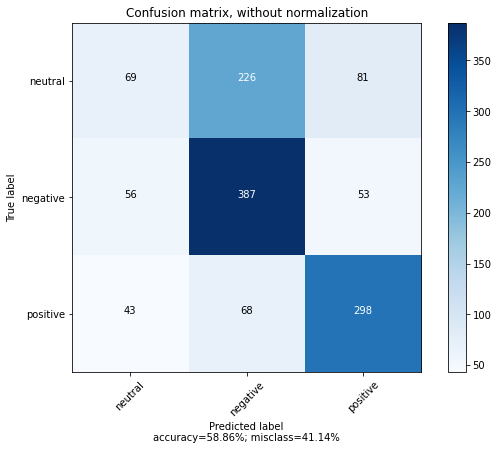

In [ ]:
main_test_postreply()